In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np
import torch
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

Configure encoder to make predictions using weights from a previous training run:

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2_redbin3.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("config_dc2_redbin3", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Configure the test dataloader:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

Load in encoder weights:

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [5]:
confidence_levels = torch.linspace(0.05, 0.95, steps = 19)

ci_quantiles = torch.distributions.Normal(0, 1).icdf(1 - (1 - confidence_levels)/2).to(device)

In [6]:
b = next(iter(test_dl))
    
batch = move_data_to_device(b, device)

with torch.no_grad():
    input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
    inputs = torch.cat(input_lst, dim=2)

    x_cat_marginal = encoder.net(inputs).squeeze().flatten(0,1).unsqueeze(-1)

In [7]:
shear1_true = torch.zeros(len(test_dl), 64, 3, device='cpu')
shear2_true = torch.zeros(len(test_dl), 64, 3, device='cpu')
convergence_true = torch.zeros(len(test_dl), 64, 3, device='cpu')

shear1_ci_lower = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')
shear1_ci_upper = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')
shear2_ci_lower = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')
shear2_ci_upper = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')
convergence_ci_lower = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')
convergence_ci_upper = torch.zeros(len(test_dl), 64, 3, len(ci_quantiles), device='cpu')

i = -1
for b in test_dl:
    i += 1
    print(i)
    batch = move_data_to_device(b, device)
    
    with torch.no_grad():
        shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze().flatten(0,1)
        shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze().flatten(0,1)
        convergence_true[i] = batch['tile_catalog']['convergence'].squeeze().flatten(0,1)

        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)

        x_cat_marginal = encoder.net(inputs).squeeze().flatten(0,1).unsqueeze(-1)

        shear1_ci_lower[i] = x_cat_marginal[:,0:3,:] - ci_quantiles * x_cat_marginal[:,3:6,:].exp().sqrt()
        shear1_ci_upper[i] = x_cat_marginal[:,0:3,:] + ci_quantiles * x_cat_marginal[:,3:6,:].exp().sqrt()
        shear2_ci_lower[i] = x_cat_marginal[:,6:9,:] - ci_quantiles * x_cat_marginal[:,9:12,:].exp().sqrt()
        shear2_ci_upper[i] = x_cat_marginal[:,6:9,:] + ci_quantiles * x_cat_marginal[:,9:12,:].exp().sqrt()
        convergence_ci_lower[i] = x_cat_marginal[:,12:15,:] - ci_quantiles * x_cat_marginal[:,15:18,:].exp().sqrt()
        convergence_ci_upper[i] = x_cat_marginal[:,12:15,:] + ci_quantiles * x_cat_marginal[:,15:18,:].exp().sqrt()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [8]:
shear1_coverage_probs = ((shear1_ci_lower.flatten(0,1) <= shear1_true.flatten(0,1).unsqueeze(-1)) * (shear1_true.flatten(0,1).unsqueeze(-1) <= shear1_ci_upper.flatten(0,1))).float().mean(0)
shear2_coverage_probs = ((shear2_ci_lower.flatten(0,1) <= shear2_true.flatten(0,1).unsqueeze(-1)) * (shear2_true.flatten(0,1).unsqueeze(-1) <= shear2_ci_upper.flatten(0,1))).float().mean(0)
convergence_coverage_probs = ((convergence_ci_lower.flatten(0,1) <= convergence_true.flatten(0,1).unsqueeze(-1)) * (convergence_true.flatten(0,1).unsqueeze(-1) <= convergence_ci_upper.flatten(0,1))).float().mean(0)

In [9]:
for b in range(3):
    print(f'Redshift bin {b}:')
    for i, ci in enumerate(confidence_levels):
        print(f'Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[b,i]:.4f}, Shear 2: {shear2_coverage_probs[b,i]:.4f}, Convergence: {convergence_coverage_probs[b,i]:.4f}')
    print('\n')

Redshift bin 0:
Confidence level: 0.05, Shear 1: 0.0848, Shear 2: 0.0547, Convergence: 0.0605
Confidence level: 0.10, Shear 1: 0.1688, Shear 2: 0.1109, Convergence: 0.1230
Confidence level: 0.15, Shear 1: 0.2492, Shear 2: 0.1695, Convergence: 0.1828
Confidence level: 0.20, Shear 1: 0.3203, Shear 2: 0.2324, Convergence: 0.2352
Confidence level: 0.25, Shear 1: 0.3922, Shear 2: 0.2812, Convergence: 0.2922
Confidence level: 0.30, Shear 1: 0.4578, Shear 2: 0.3402, Convergence: 0.3531
Confidence level: 0.35, Shear 1: 0.5266, Shear 2: 0.4047, Convergence: 0.4133
Confidence level: 0.40, Shear 1: 0.5859, Shear 2: 0.4563, Convergence: 0.4742
Confidence level: 0.45, Shear 1: 0.6406, Shear 2: 0.5125, Convergence: 0.5293
Confidence level: 0.50, Shear 1: 0.6980, Shear 2: 0.5672, Convergence: 0.5793
Confidence level: 0.55, Shear 1: 0.7410, Shear 2: 0.6168, Convergence: 0.6309
Confidence level: 0.60, Shear 1: 0.7844, Shear 2: 0.6695, Convergence: 0.6766
Confidence level: 0.65, Shear 1: 0.8246, Shear 2

Redshift bin 0:

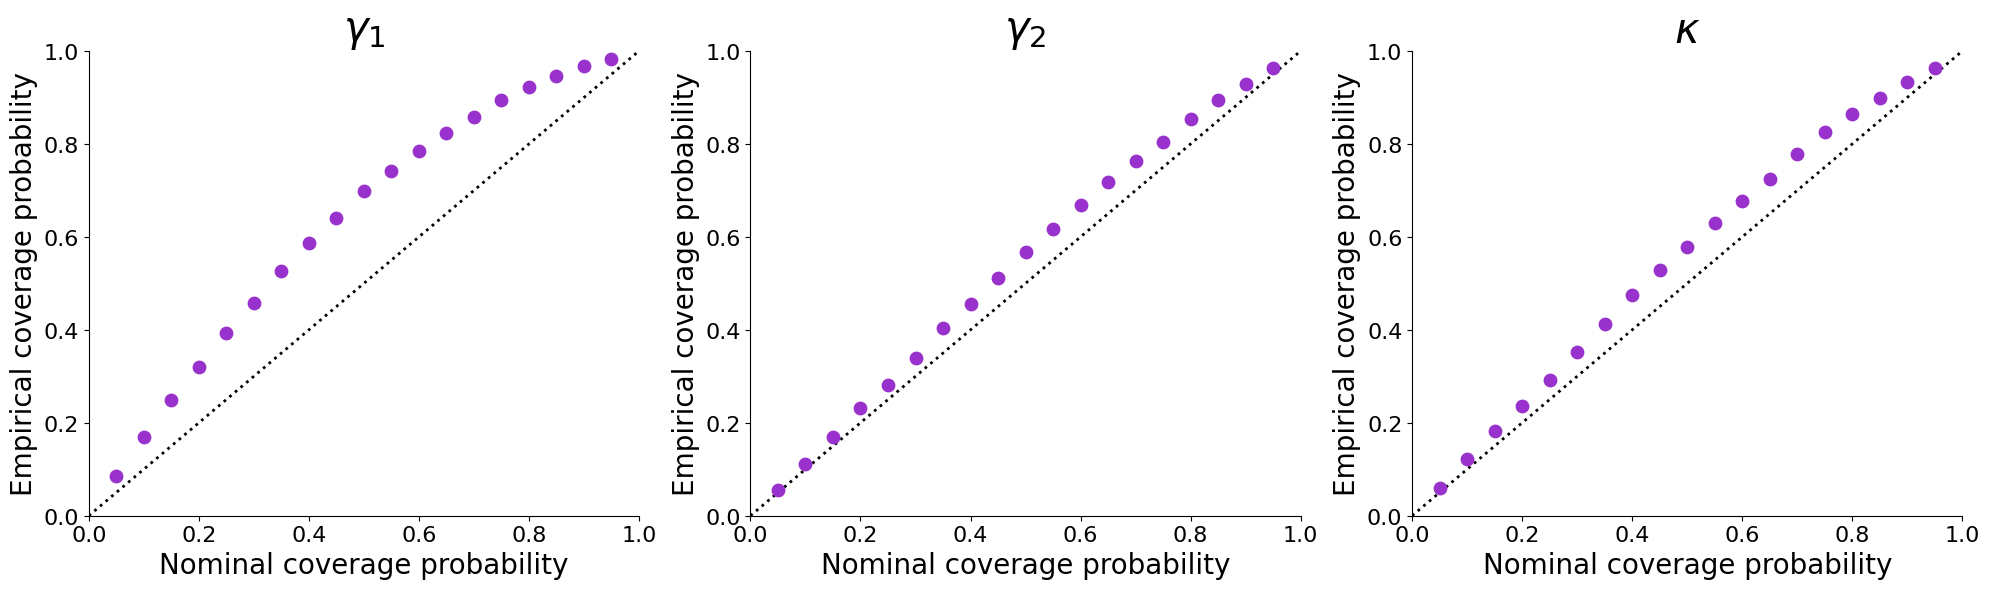

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fontsize = 20
ticklabelsize = 16
color = 'darkorchid'
s = 80

# Specify redshift bin
b = 0

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[0].set_title('$\gamma_1$', fontsize=1.5*fontsize)
_ = ax[0].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[0].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[1].set_title('$\gamma_2$', fontsize=1.5*fontsize)
_ = ax[1].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[1].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[2].scatter(confidence_levels, convergence_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[2].set_title('$\kappa$', fontsize=1.5*fontsize)
_ = ax[2].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[2].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim(0, 1)
_ = ax[2].set_ylim(0, 1)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/coverageprobs_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

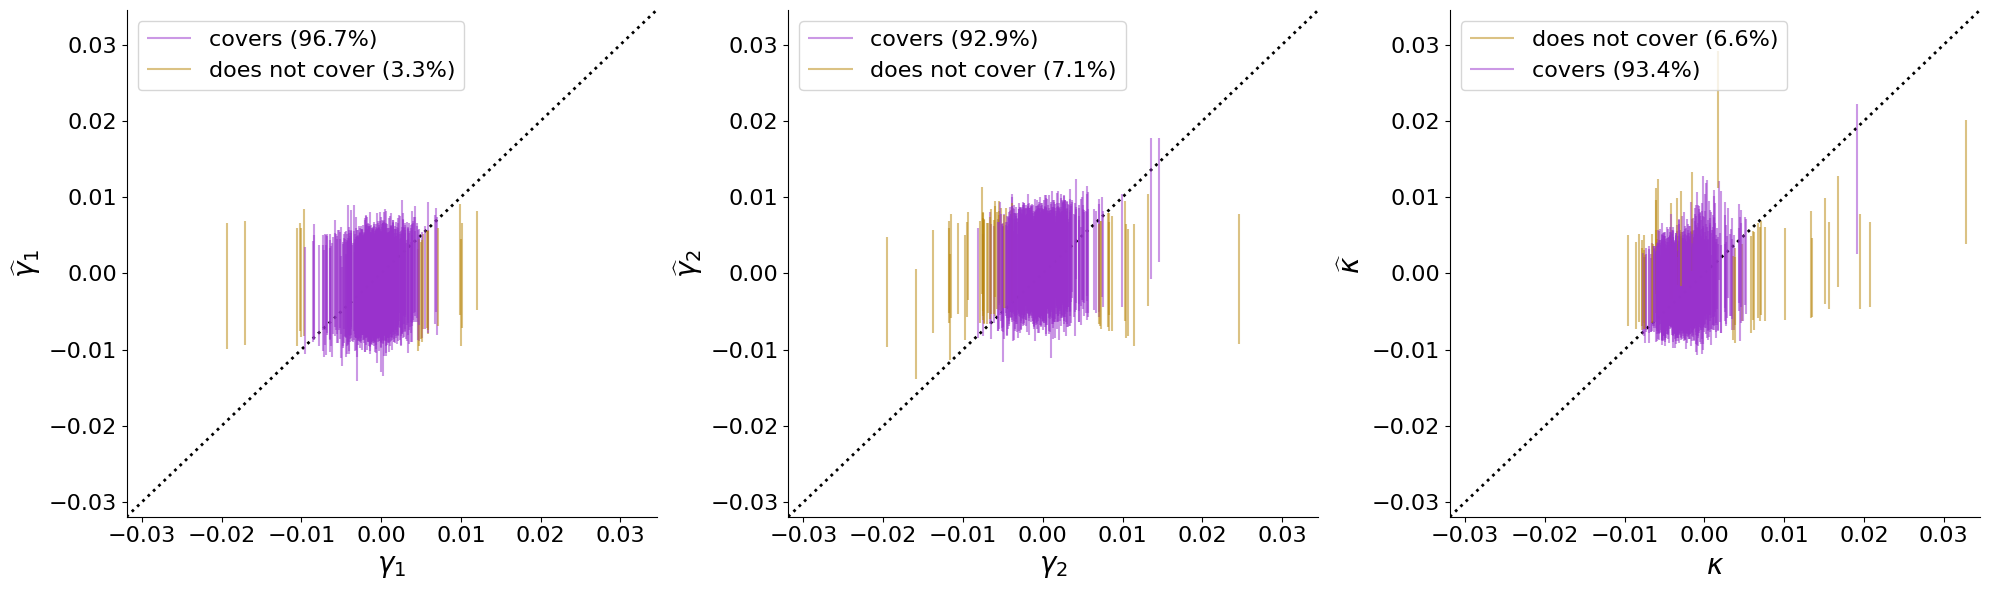

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fontsize = 20
ticklabelsize = 16
color = np.array(['darkgoldenrod','darkorchid'])
alpha = 0.5

# Specify redshift bin
b = 0

axmin = min(shear1_ci_lower[:,:,b,:].min(), shear2_ci_lower[:,:,b,:].min(), convergence_ci_lower[:,:,b,:].min()).cpu() - 0.01
axmax = max(shear1_ci_upper[:,:,b,:].max(), shear2_ci_upper[:,:,b,:].max(), convergence_ci_upper[:,:,b,:].quantile(0.995)).cpu() + 0.01

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower[:,:,b,:].flatten(0,1) <= shear1_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_xlabel('$\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower[:,:,b,:].flatten(0,1) <= shear2_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('$\gamma_2$', fontsize=fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower[:,:,b,:].flatten(0,1) <= convergence_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_xlabel('$\kappa$', fontsize=fontsize)
_ = ax[2].set_ylabel(r'$\widehat{\kappa}$', fontsize=fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 1:

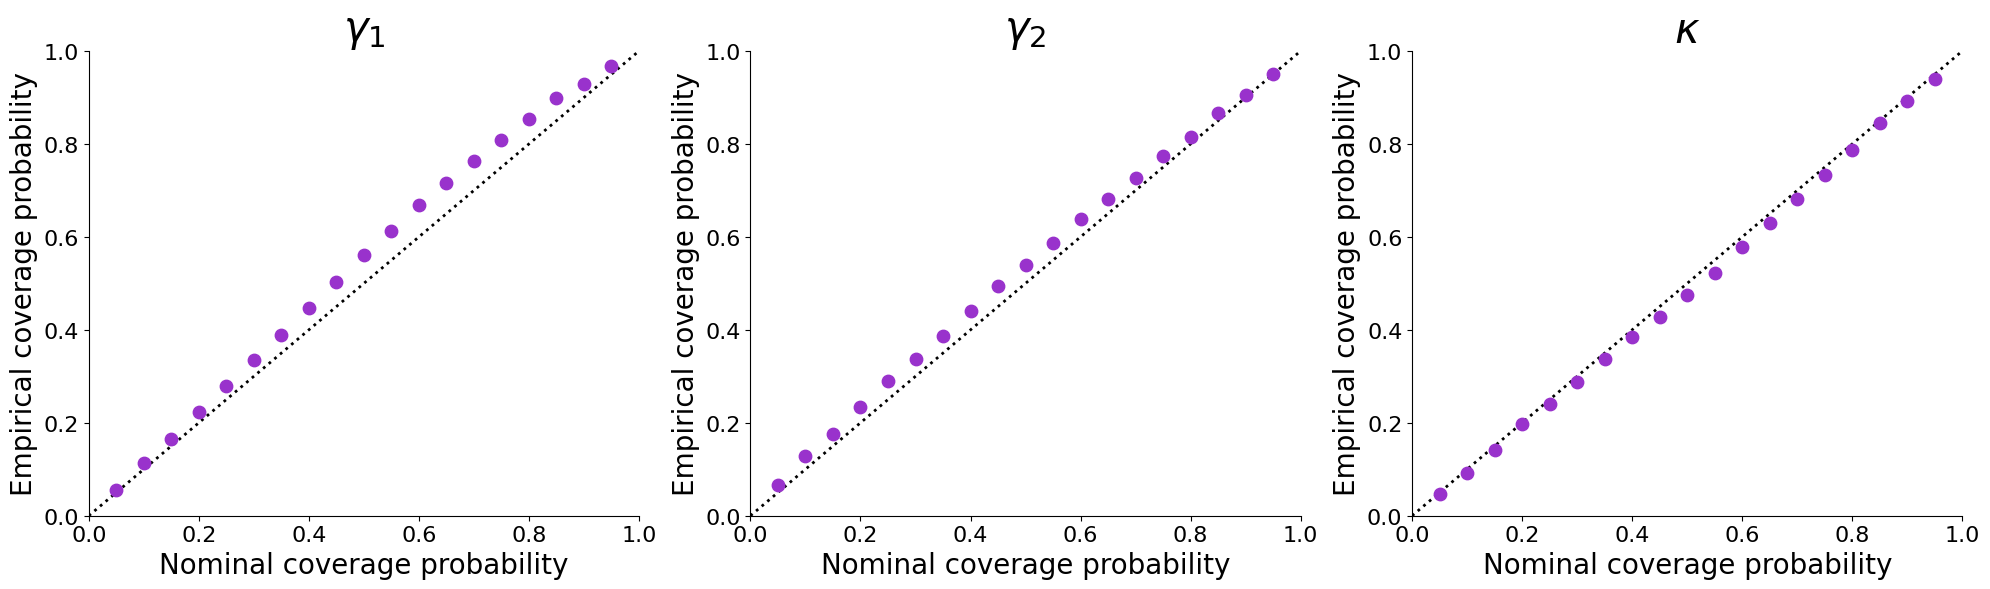

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fontsize = 20
ticklabelsize = 16
color = 'darkorchid'
s = 80

# Specify redshift bin
b = 1

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[0].set_title('$\gamma_1$', fontsize=1.5*fontsize)
_ = ax[0].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[0].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[1].set_title('$\gamma_2$', fontsize=1.5*fontsize)
_ = ax[1].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[1].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[2].scatter(confidence_levels, convergence_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[2].set_title('$\kappa$', fontsize=1.5*fontsize)
_ = ax[2].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[2].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim(0, 1)
_ = ax[2].set_ylim(0, 1)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/coverageprobs_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

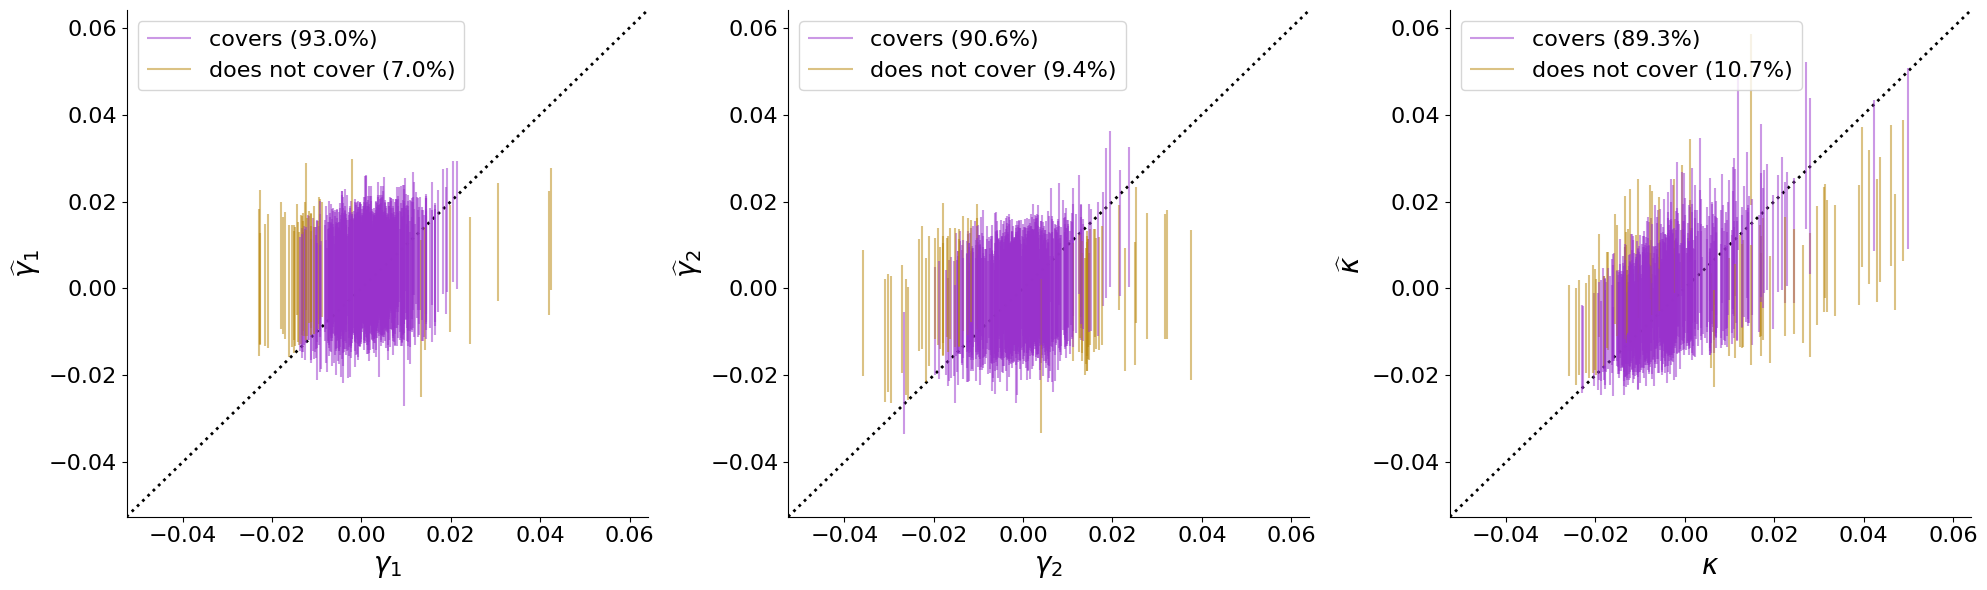

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fontsize = 20
ticklabelsize = 16
color = np.array(['darkgoldenrod','darkorchid'])
alpha = 0.5

# Specify redshift bin
b = 1

axmin = min(shear1_ci_lower[:,:,b,:].min(), shear2_ci_lower[:,:,b,:].min(), convergence_ci_lower[:,:,b,:].min()).cpu() - 0.01
axmax = max(shear1_ci_upper[:,:,b,:].max(), shear2_ci_upper[:,:,b,:].max(), convergence_ci_upper[:,:,b,:].quantile(0.995)).cpu() + 0.01

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower[:,:,b,:].flatten(0,1) <= shear1_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_xlabel('$\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower[:,:,b,:].flatten(0,1) <= shear2_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('$\gamma_2$', fontsize=fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower[:,:,b,:].flatten(0,1) <= convergence_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_xlabel('$\kappa$', fontsize=fontsize)
_ = ax[2].set_ylabel(r'$\widehat{\kappa}$', fontsize=fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 2:

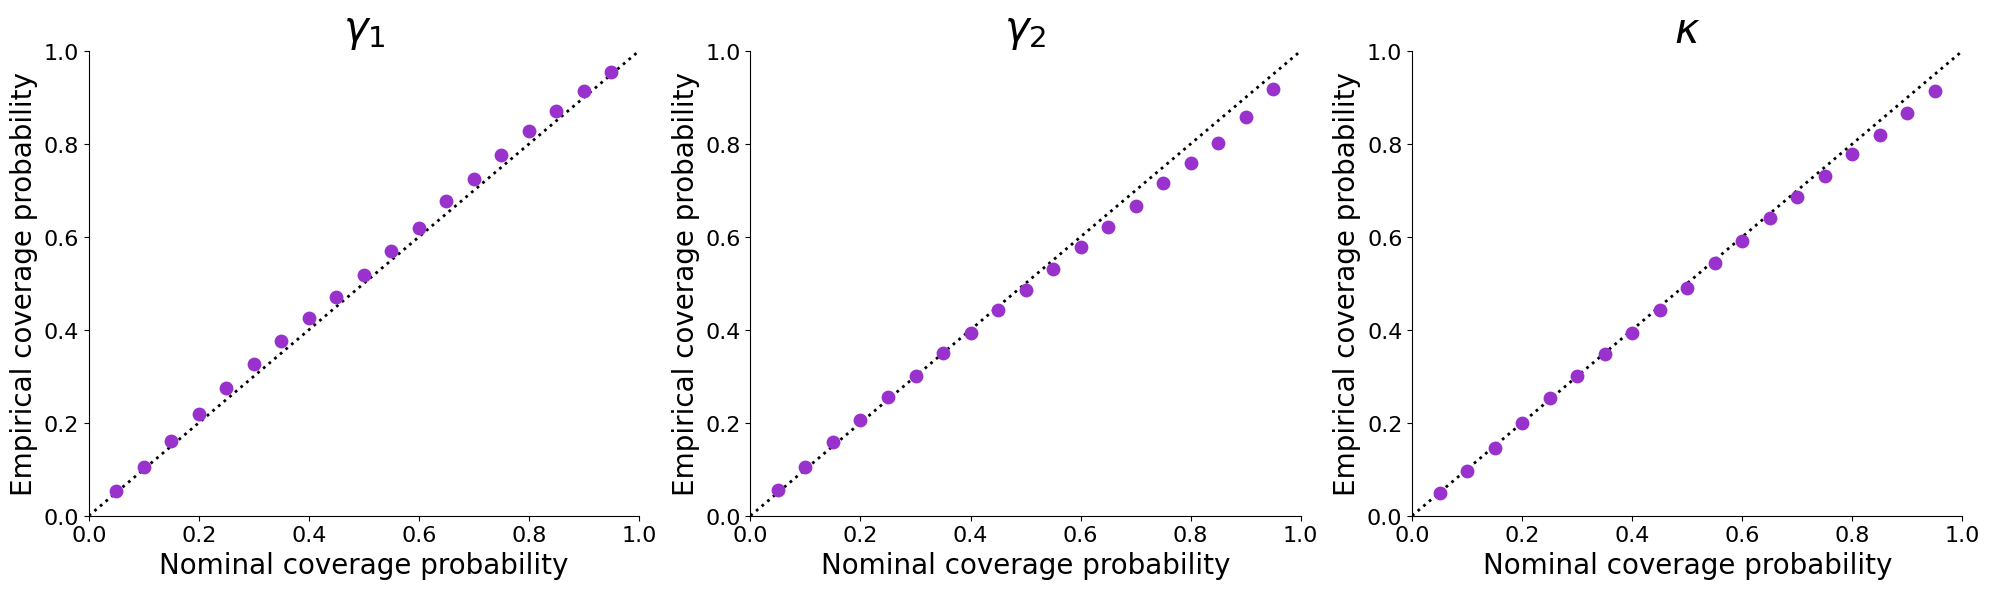

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fontsize = 20
ticklabelsize = 16
color = 'darkorchid'
s = 80

# Specify redshift bin
b = 2

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[0].set_title('$\gamma_1$', fontsize=1.5*fontsize)
_ = ax[0].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[0].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[1].set_title('$\gamma_2$', fontsize=1.5*fontsize)
_ = ax[1].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[1].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[2].scatter(confidence_levels, convergence_coverage_probs[b], color=color, s=s, zorder=1)
_ = ax[2].set_title('$\kappa$', fontsize=1.5*fontsize)
_ = ax[2].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[2].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim(0, 1)
_ = ax[2].set_ylim(0, 1)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/coverageprobs_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

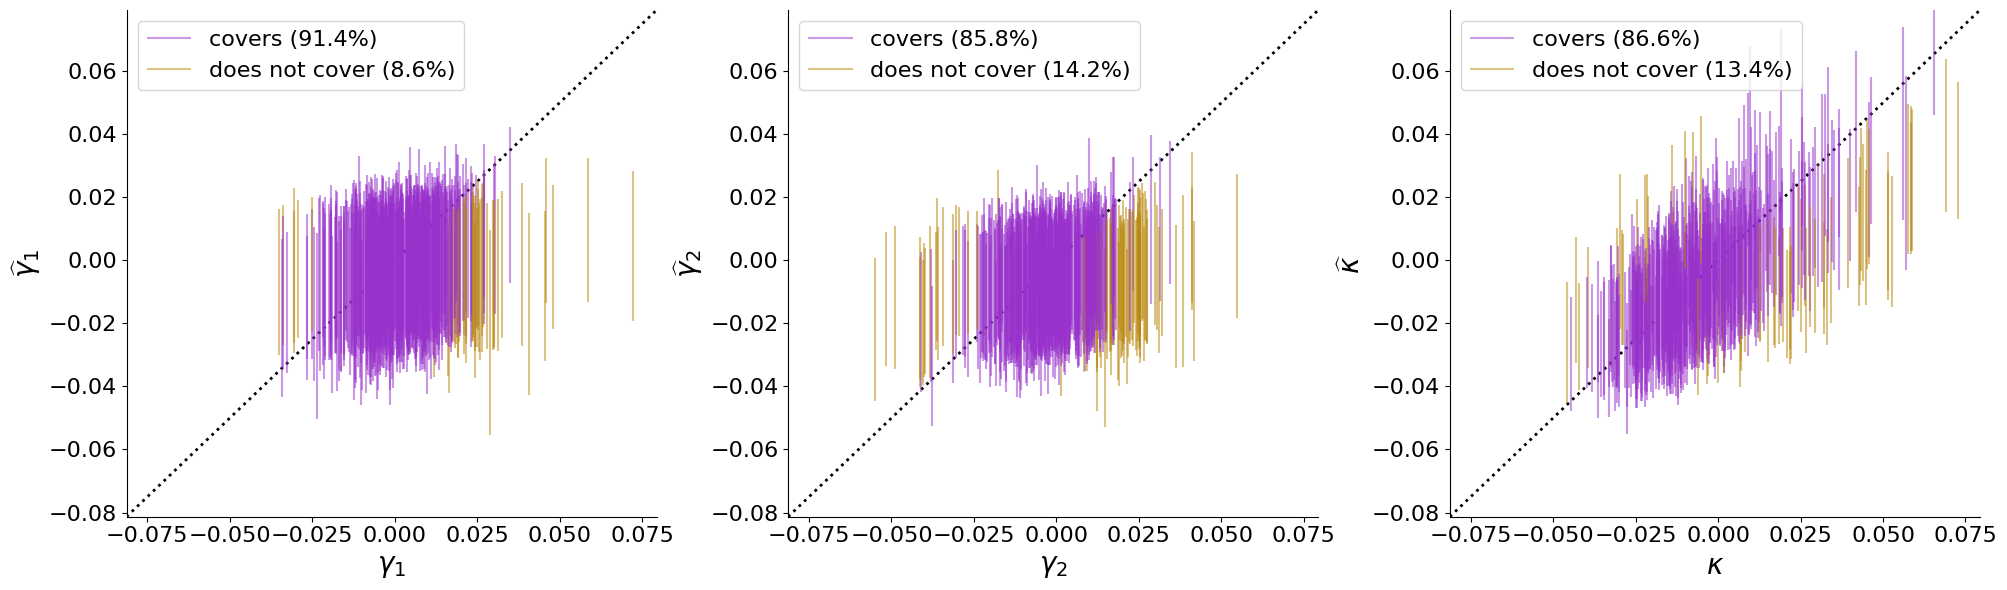

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fontsize = 20
ticklabelsize = 16
color = np.array(['darkgoldenrod','darkorchid'])
alpha = 0.5

# Specify redshift bin
b = 2

axmin = min(shear1_ci_lower[:,:,b,:].min(), shear2_ci_lower[:,:,b,:].min(), convergence_ci_lower[:,:,b,:].min()).cpu() - 0.01
axmax = max(shear1_ci_upper[:,:,b,:].max(), shear2_ci_upper[:,:,b,:].max(), convergence_ci_upper[:,:,b,:].quantile(0.995)).cpu() + 0.01

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower[:,:,b,:].flatten(0,1) <= shear1_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_xlabel('$\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower[:,:,b,:].flatten(0,1) <= shear2_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('$\gamma_2$', fontsize=fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower[:,:,b,:].flatten(0,1) <= convergence_true[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[b,interval_idx].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[b,interval_idx].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_xlabel('$\kappa$', fontsize=fontsize)
_ = ax[2].set_ylabel(r'$\widehat{\kappa}$', fontsize=fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)